In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import time
from tqdm.notebook import tqdm

from proteolizarddata.data import PyTimsDataHandle, TimsFrame, MzSpectrum
from proteolizardalgo.hashing import TimsHasher, IsotopeReferenceSearch, ReferencePattern
from proteolizardalgo.utility import create_reference_dict, get_refspec_list, get_ref_pattern_as_spectra

import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import KDTree

In [2]:
dh = PyTimsDataHandle('../data/M210115_001_Slot1-1_1_850.d/')

In [7]:
ref_hashes = pd.read_parquet('synthetic_patterns_last_contrib.parquet')
d_list = get_refspec_list(get_ref_pattern_as_spectra(ref_hashes), win_len=4)
d = create_reference_dict(d_list)

creating reference patterns: 100%|███████████████████████████| 17857/17857 [02:04<00:00, 143.78it/s]


In [3]:
WINDOW_LENGTH = 10
RESOLUTION = 1

In [17]:
# generate hasher
hasher = TimsHasher(trials=32, len_trial=32, seed=42, num_dalton=WINDOW_LENGTH, resolution=RESOLUTION)

In [18]:
for f in tqdm(dh.precursor_frames[1800:]):
    frame = dh.get_frame(f)
    
    frame_filtered = hasher.filter_frame_auto_correlation(frame, min_intensity=50, min_peaks=3)
    
    break

  0%|          | 0/7005 [00:00<?, ?it/s]

In [19]:
frame_filtered.data()

,frame,scan,mz,intensity
0,19797,68,1155.516671,54
1,19797,68,1155.554123,77
2,19797,68,1156.544157,32
3,19797,71,1090.494220,132
4,19797,71,1090.582581,42
...,...,...,...,...
60819,19797,838,464.074023,119
60820,19797,842,462.840653,18
60821,19797,875,760.906629,80
60822,19797,875,763.831400,30


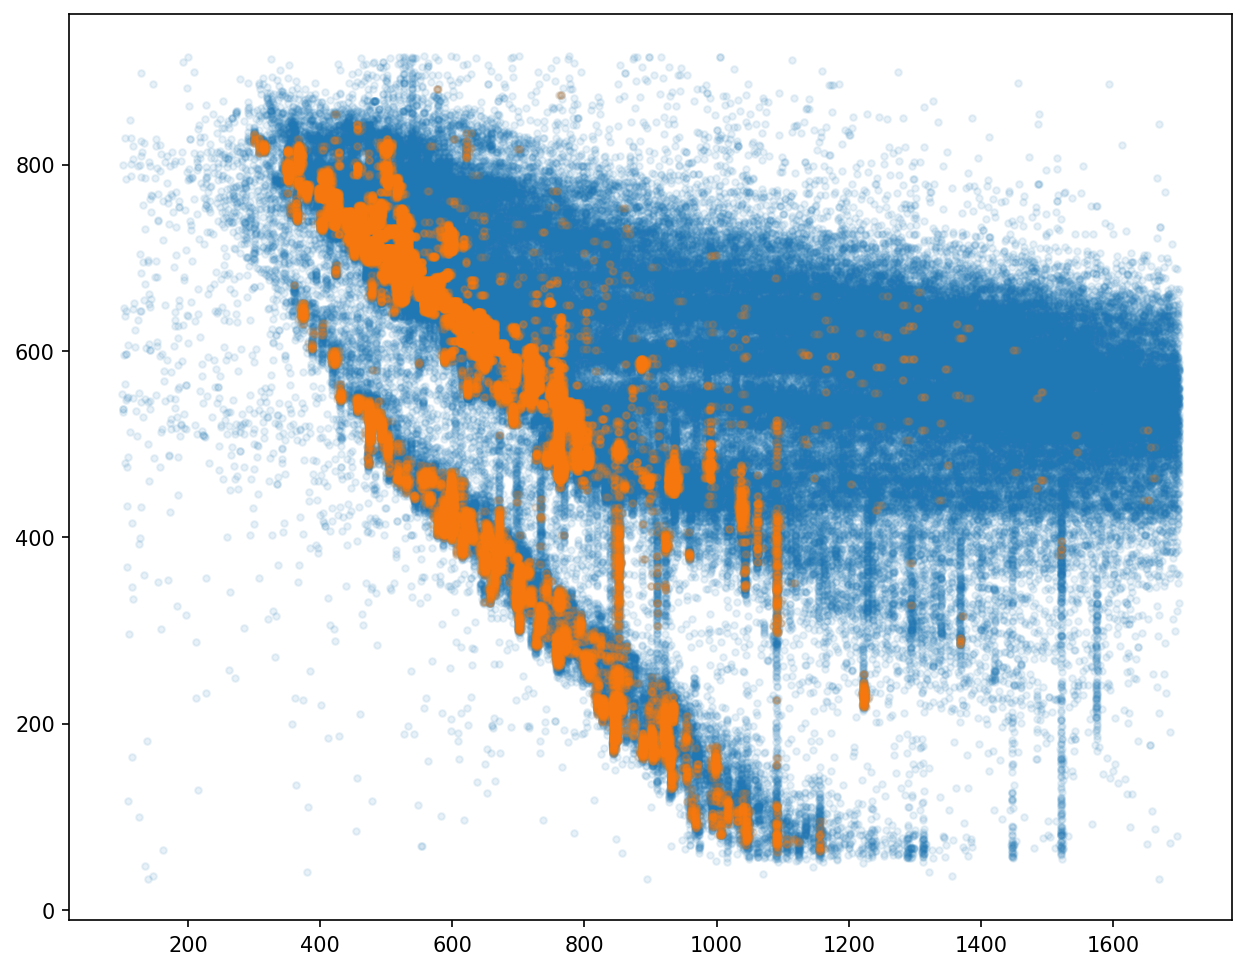

In [20]:
plt.figure(figsize=(10, 8), dpi=150)
plt.scatter(frame.data().mz, frame.data().scan, s=10, alpha=.1)
plt.scatter(frame_filtered.data().mz, frame_filtered.data().scan, s=10, alpha=.1)
plt.show()

In [33]:
frame_filtered.data()

,frame,scan,mz,intensity
0,19797,57,1061.540924,68
1,19797,57,1062.592450,20
2,19797,57,1062.607842,10
3,19797,60,1123.637823,20
4,19797,60,1124.603535,73
...,...,...,...,...
89168,19797,850,519.414527,161
89169,19797,850,521.288689,59
89170,19797,855,539.195785,23
89171,19797,855,539.261574,91


In [ ]:
plt.figure(figsize=(10, 6), dpi=150)
plt.scatter(frame_filtered.mz(), frame_filtered.scan(), alpha=0.2, s=10)
plt.show()

In [ ]:
ref_hasher = TimsHasher(trials=512, len_trial=22, seed=42, num_dalton=4, resolution=2)
ref_search = IsotopeReferenceSearch(d, hasher=ref_hasher)

In [ ]:
patterns = ref_search.find_isotope_patterns(frame_filtered, min_intensity=100, min_peaks=4, overlapping=True)

color_dict = {1:'lightblue', 2:'orange', 3:'red', 4:'yellow', 5:'yellow'}
plt.figure(figsize=(10, 6), dpi=150)
plt.scatter(patterns.mz_mono, patterns.scan, color=[color_dict[x] for x in patterns.charge.values], s=10)
plt.show()

In [ ]:
dda_precursors = dh.get_selected_precursors()
all_parent_ids = sorted(list(set(dda_precursors.Parent)))

prec = dda_precursors[dda_precursors.Parent == frame_filtered.frame_id()].sort_values('MonoisotopicMz').dropna()
prec['MonoisotopicMz'] = np.round(prec['MonoisotopicMz'], 2)
prec['ScanNumber'] = np.round(prec['ScanNumber'])

kdt = KDTree(patterns[['scan', 'charge', 'mz_mono']].values, leaf_size=30, metric='euclidean')
distance, index = kdt.query(prec[['ScanNumber', 'Charge', 'MonoisotopicMz']].values)

matched = pd.DataFrame(np.hstack((np.squeeze(patterns[['scan', 'charge', 'mz_mono']].values[index]), 
                        prec[['MonoisotopicMz', 'ScanNumber', 'Charge']].values, distance)), 

                       columns=['scan', 'charge', 'mz_mono', 
         'MonoisotopicMz', 'ScanNumber', 'Charge', 'distance']).sort_values(['distance'])

matched['mz_diff'] = np.round(np.abs(matched['mz_mono'] - matched['MonoisotopicMz']), 2)

matched = matched.sort_values('mz_diff')

matched